In [1]:
# system
import os

# scipy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt

# nutrig
import flt.tools as tools

#plt.style.use('seaborn-v0_8-colorblind')
plt.style.use('tableau-colorblind10')
plt.style.use('/pbs/home/p/pcorrea/tools/matplotlib_style_sans-serif.txt')

%matplotlib inline

Welcome to JupyROOT 6.30/04


In [2]:
n_templates   = 3
corr_window   = [-10,10]#[-15,15]
fit_window    = [-10,30]
pol           = 'XY'
n_pol         = len(pol)
dataset       = 'train' # or 'test' for final checks
snr_bin_width = 1

plot_dir = '/pbs/home/p/pcorrea/grand/nutrig/plots'
savefig  = False

param_str = f'templates_{n_templates}_cw_{corr_window[0]}_{corr_window[1]}_fw_{fit_window[0]}_{fit_window[1]}'

#bkg_res_file     = f'/sps/grand/pcorrea/nutrig/template/results/results_template_FLT_{pol}_bkg_dataset_nutrig_gp13_{dataset}_seed_300_{param_str}.npz'
#bkg_res_file     = f'/sps/grand/pcorrea/nutrig/template/results/results_template_FLT_{pol}_bkg_dataset_nutrig_gp13_th1_55_th2_35_{dataset}_seed_300_{param_str}.npz' # 1 kHz

sig_res_file     = f'/sps/grand/pcorrea/nutrig/template/results/results_template_FLT_{pol}_sig_dataset_nutrig_gp13_{dataset}_seed_300_{param_str}.npz'
sig_dataset_file = f'/sps/grand/pcorrea/nutrig/database/sig/sig_dataset_nutrig_gp13_{dataset}_seed_300.npz'

In [3]:
sig_results = tools.load_results(sig_res_file,n_pol)
snr_masks   = tools.get_snr_masks(sig_dataset_file,snr_bin_width=snr_bin_width)

snr_bin     = 5
corr_thresh = .5

corr_snr_bin  = sig_results['corr_max'][snr_masks[snr_bin]]
mask_low_corr = np.where(corr_snr_bin<corr_thresh)[0]

title_str = fr'Templates: {n_templates}, SNR = {snr_bin}--{snr_bin+1}, $\rho_{{\max}} < {corr_thresh}$'

In [4]:
simu_params_all = {} # all contents in SNR bin
simu_params_all['energy']          = np.zeros(corr_snr_bin.shape)
simu_params_all['zenith']          = np.zeros(corr_snr_bin.shape)
simu_params_all['azimuth']         = np.zeros(corr_snr_bin.shape)
simu_params_all['omega']           = np.zeros(corr_snr_bin.shape)
simu_params_all['omega_c']         = np.zeros(corr_snr_bin.shape)
simu_params_all['inj_pulse_times'] = np.zeros(corr_snr_bin.shape)
simu_params_all['pretrig_times']   = np.zeros(corr_snr_bin.shape)


# simu_params_below_thresh = {} # all contents below correlation threshold
# simu_params_below_thresh['energy']  = np.zeros(mask_low_corr.shape)
# simu_params_below_thresh['zenith']  = np.zeros(mask_low_corr.shape)
# simu_params_below_thresh['azimuth'] = np.zeros(mask_low_corr.shape)
# simu_params_below_thresh['omega']   = np.zeros(mask_low_corr.shape)
# simu_params_below_thresh['omega_c'] = np.zeros(mask_low_corr.shape)

In [5]:
with np.load(sig_dataset_file) as f:
    files      = f['files']
    entries    = f['entries']
    traces     = f['traces']
    max_traces = np.max( np.abs( traces[:,:2] ),axis=(1,2) ) / np.sqrt( np.mean( traces[:,:2]**2,axis=(1,2) ) )

print(np.where(files=='/sps/grand/pcorrea/nutrig/database/sig/zhaires_proton_rfv2_th1_35_th2_25/sim_plus_noise_GP300_Xi_Sib_Proton_0.481_85.2_199.9_18366_seed_6941.npz')[0])

files                       = files[snr_masks[snr_bin]]
entries                     = entries[snr_masks[snr_bin]]
traces                      = traces[snr_masks[snr_bin]]
simu_params_all['max_ampl'] = max_traces[snr_masks[snr_bin]]

for k, file, entry in zip(np.arange(len(files)),files,entries):
    with np.load(file) as f:
        simu_params_all['energy'][k]          = f['energy']
        simu_params_all['zenith'][k]          = f['zenith']
        simu_params_all['azimuth'][k]         = f['azimuth']
        simu_params_all['omega'][k]           = f['omega'][entry]
        simu_params_all['omega_c'][k]         = f['omega_c']
        simu_params_all['inj_pulse_times'][k] = f['inj_pulse_times'][entry]
        simu_params_all['pretrig_times'][k]   = f['pretrig_times'][entry]
simu_params_all['omega_diff'] = np.abs( simu_params_all['omega']-simu_params_all['omega_c'] )/simu_params_all['omega_c']

simu_params_below_thresh = {} # all contents below correlation threshold
for key in simu_params_all.keys():
    simu_params_below_thresh[key] = simu_params_all[key][mask_low_corr]

[ 319  611  851  958 2095 2336 3265 5730 6260 7601 7668 7826 8123]


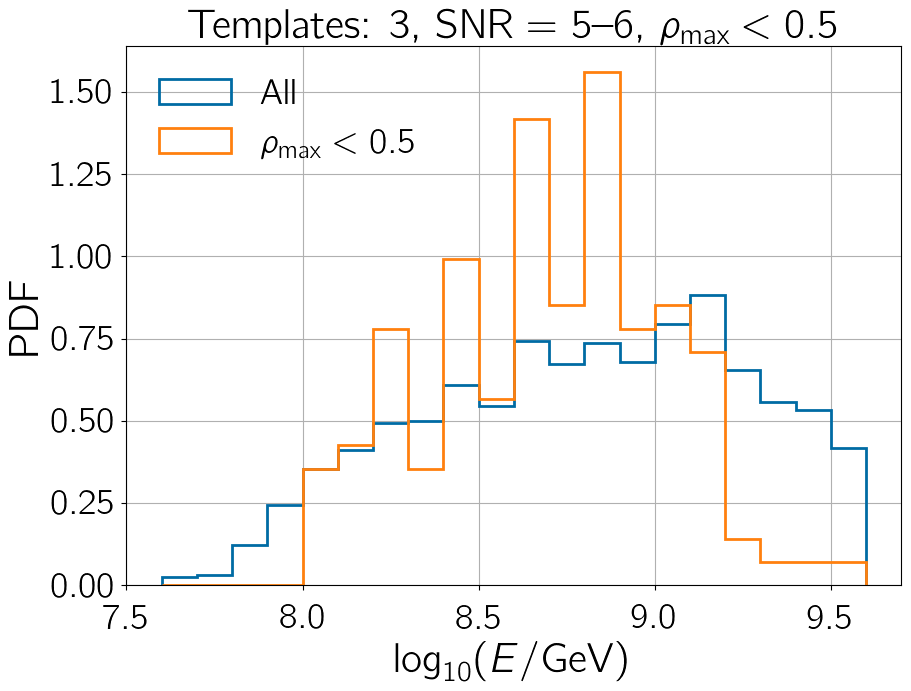

In [6]:
bins_energy = np.linspace(7.6,9.6,21)

plt.hist(np.log10(simu_params_all['energy']),bins=bins_energy,density=True,histtype='step',linewidth=2.,label='All')
plt.hist(np.log10(simu_params_below_thresh['energy']),bins=bins_energy,density=True,histtype='step',linewidth=2.,label=fr'$\rho_{{\max}} < {corr_thresh}$')
plt.xlabel(r'$\log_{10}(E/\mathrm{GeV})$')
plt.ylabel('PDF')
plt.title(title_str)
plt.legend()
plt.show()

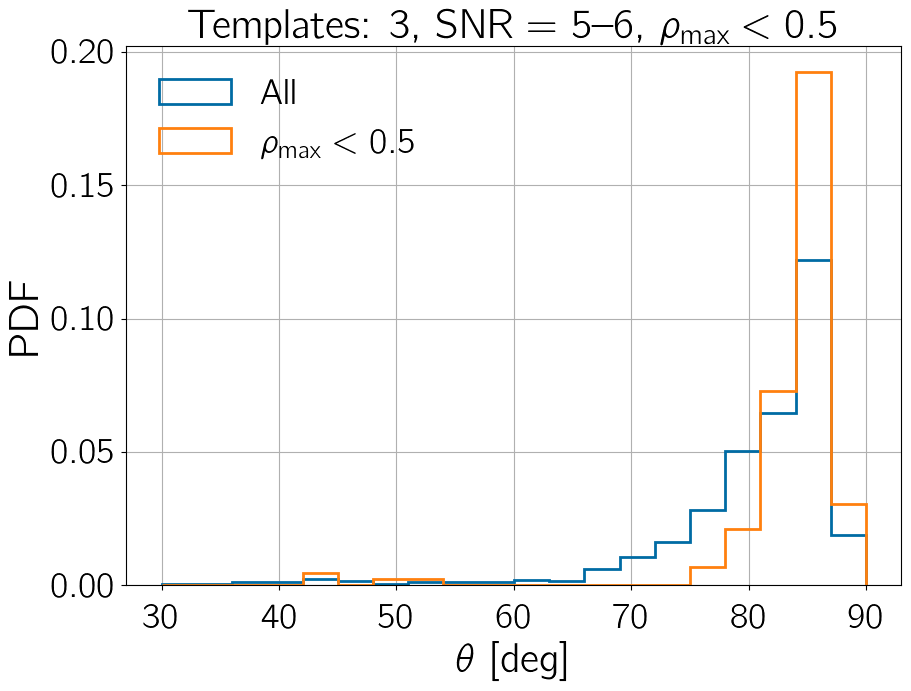

In [7]:
bins_zenith = np.linspace(30,90,21)

plt.hist(simu_params_all['zenith'],bins=bins_zenith,density=True,histtype='step',linewidth=2.,label='All')
plt.hist(simu_params_below_thresh['zenith'],bins=bins_zenith,density=True,histtype='step',linewidth=2.,label=fr'$\rho_{{\max}} < {corr_thresh}$')
plt.xlabel(r'$\theta$ [deg]')
plt.ylabel('PDF')
plt.title(title_str)
plt.legend()
plt.show()

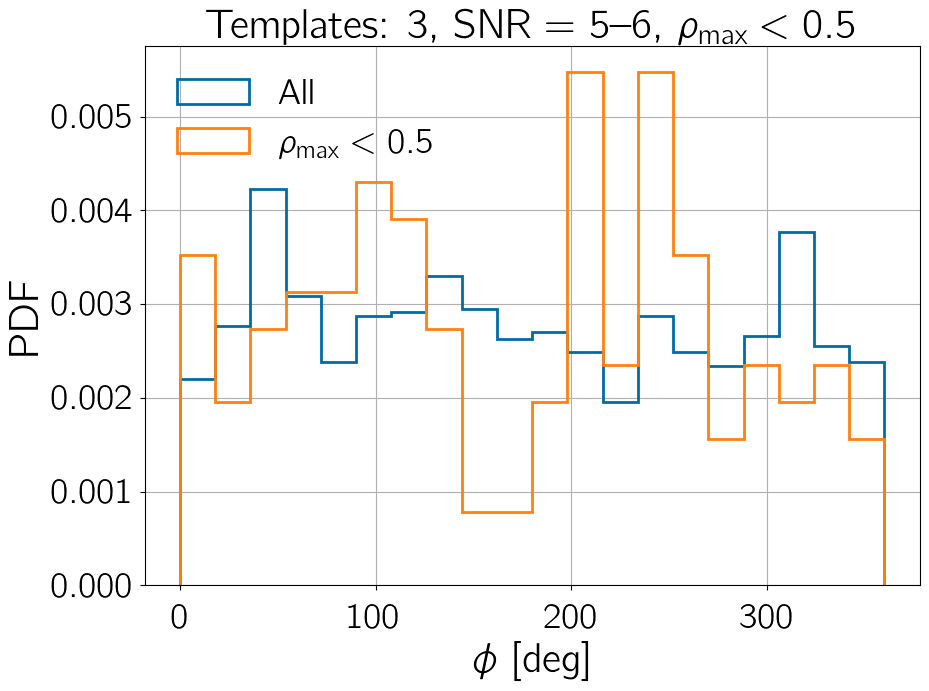

In [8]:
bins_azimuth = np.linspace(0,360,21)

plt.hist(simu_params_all['azimuth'],bins=bins_azimuth,density=True,histtype='step',linewidth=2.,label='All')
plt.hist(simu_params_below_thresh['azimuth'],bins=bins_azimuth,density=True,histtype='step',linewidth=2.,label=fr'$\rho_{{\max}} < {corr_thresh}$')
plt.xlabel(r'$\phi$ [deg]')
plt.ylabel('PDF')
plt.title(title_str)
plt.legend()
plt.show()

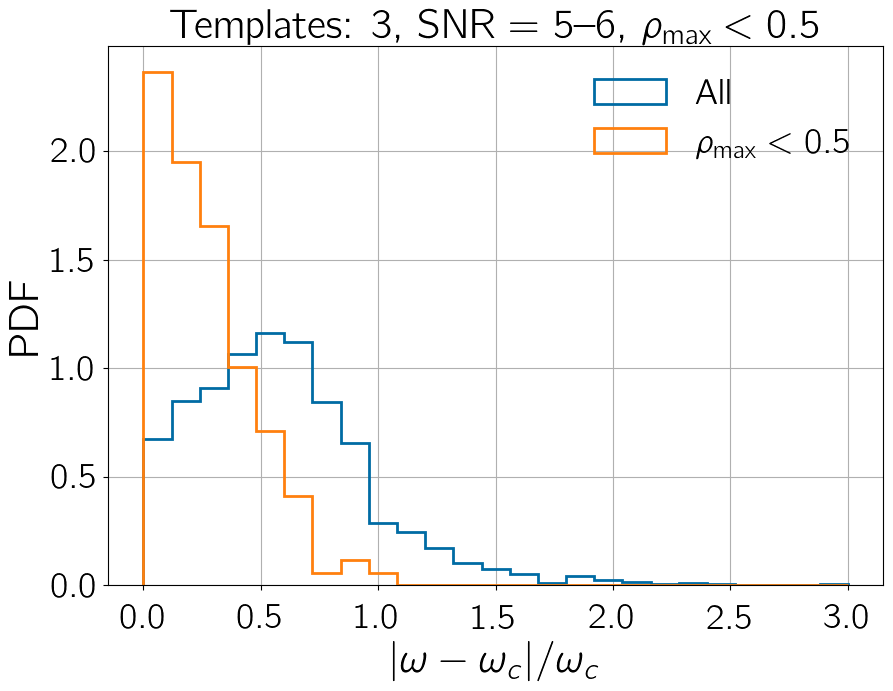

In [9]:
bins_omega_diff = np.linspace(0,3,26)

plt.hist(simu_params_all['omega_diff'],bins=bins_omega_diff,density=True,histtype='step',linewidth=2.,label='All')
plt.hist(simu_params_below_thresh['omega_diff'],bins=bins_omega_diff,density=True,histtype='step',linewidth=2.,label=fr'$\rho_{{\max}} < {corr_thresh}$')
plt.xlabel(r'$|\omega - \omega_c|/\omega_c$')
plt.ylabel('PDF')
plt.title(title_str)
plt.legend()
plt.show()

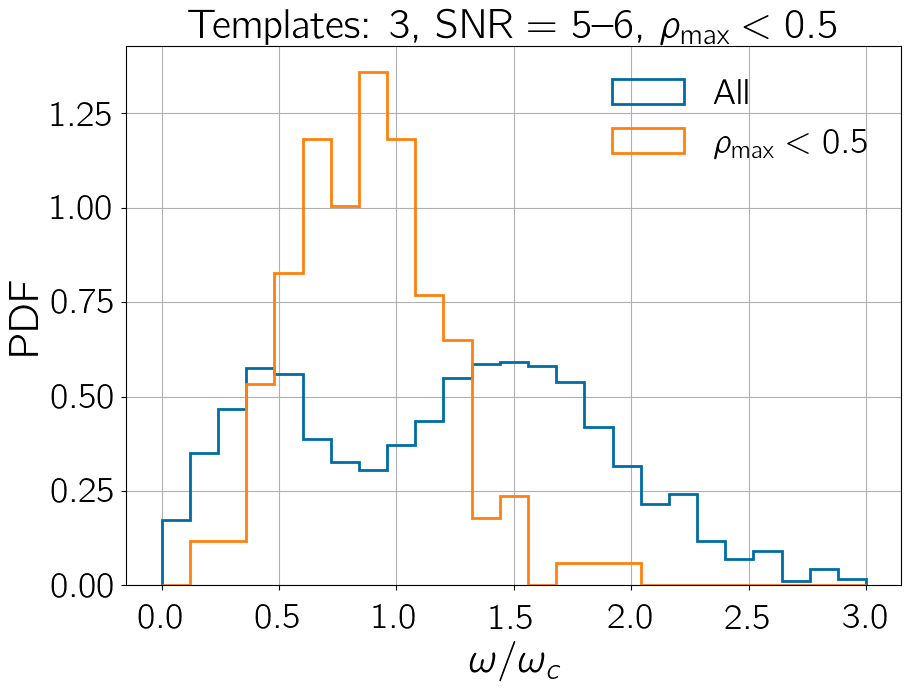

In [10]:
bins_omega = np.linspace(0,3,26)

plt.hist(simu_params_all['omega']/simu_params_all['omega_c'],bins=bins_omega,density=True,histtype='step',linewidth=2.,label='All')
plt.hist(simu_params_below_thresh['omega']/simu_params_below_thresh['omega_c'],bins=bins_omega,density=True,histtype='step',linewidth=2.,label=fr'$\rho_{{\max}} < {corr_thresh}$')
plt.xlabel(r'$\omega/\omega_c$')
plt.ylabel('PDF')
plt.title(title_str)
plt.legend()
plt.show()

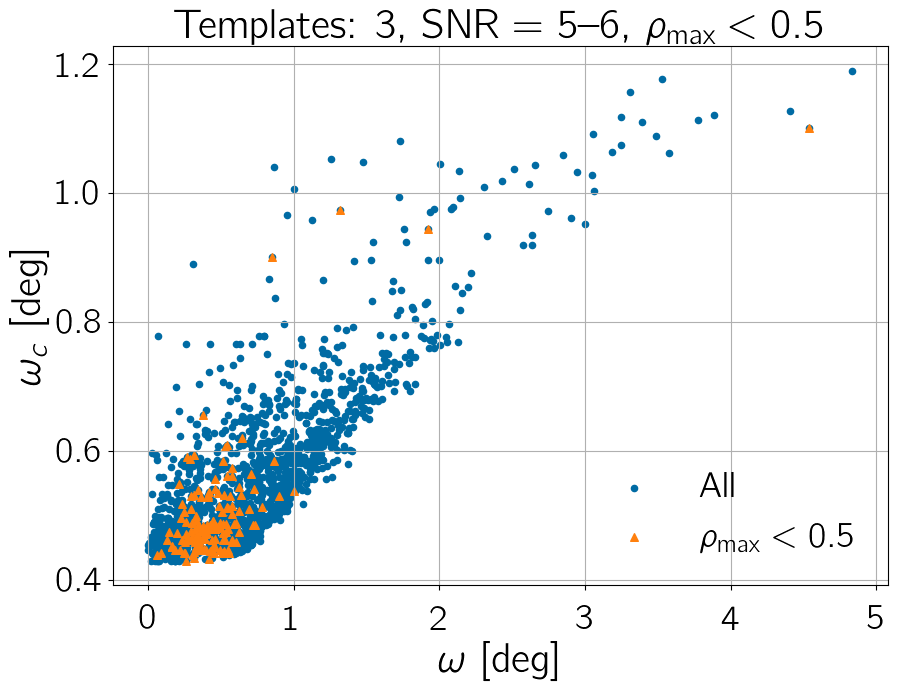

In [11]:
plt.scatter(simu_params_all['omega'],simu_params_all['omega_c'],s=20,label='All')
plt.scatter(simu_params_below_thresh['omega'],simu_params_below_thresh['omega_c'],s=30,marker='^',label=fr'$\rho_{{\max}} < {corr_thresh}$')
plt.xlabel('$\omega$ [deg]')
plt.ylabel('$\omega_c$ [deg]')
plt.title(title_str)
plt.legend()
plt.show()

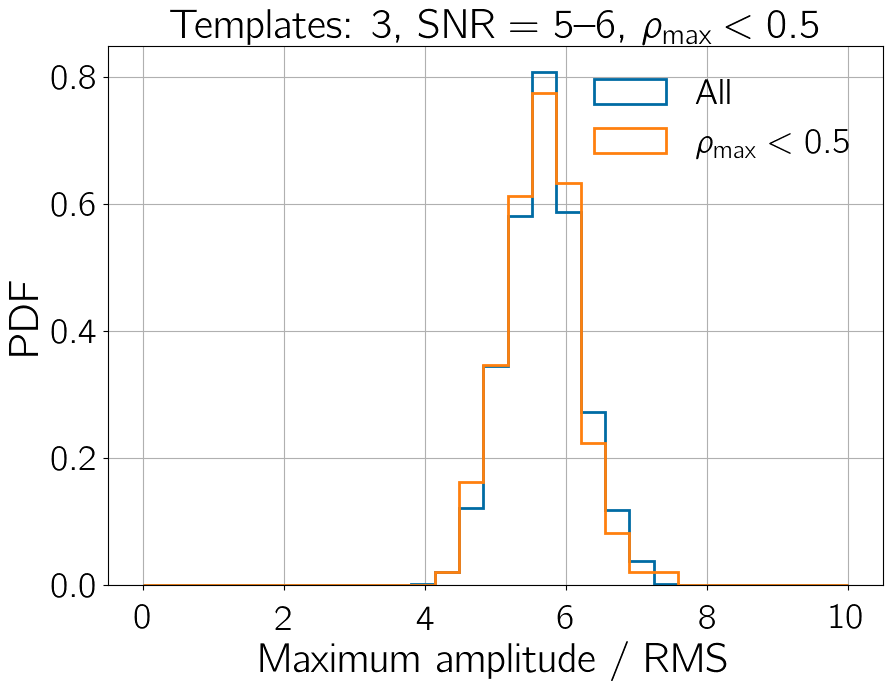

In [12]:
bins_ampl = np.linspace(0,10,30)

plt.hist(simu_params_all['max_ampl'],bins=bins_ampl,density=True,histtype='step',linewidth=2.,label='All')
plt.hist(simu_params_below_thresh['max_ampl'],bins=bins_ampl,density=True,histtype='step',linewidth=2.,label=fr'$\rho_{{\max}} < {corr_thresh}$')
plt.xlabel(r'Maximum amplitude / RMS')
plt.ylabel('PDF')
plt.title(title_str)
plt.legend()
plt.show()

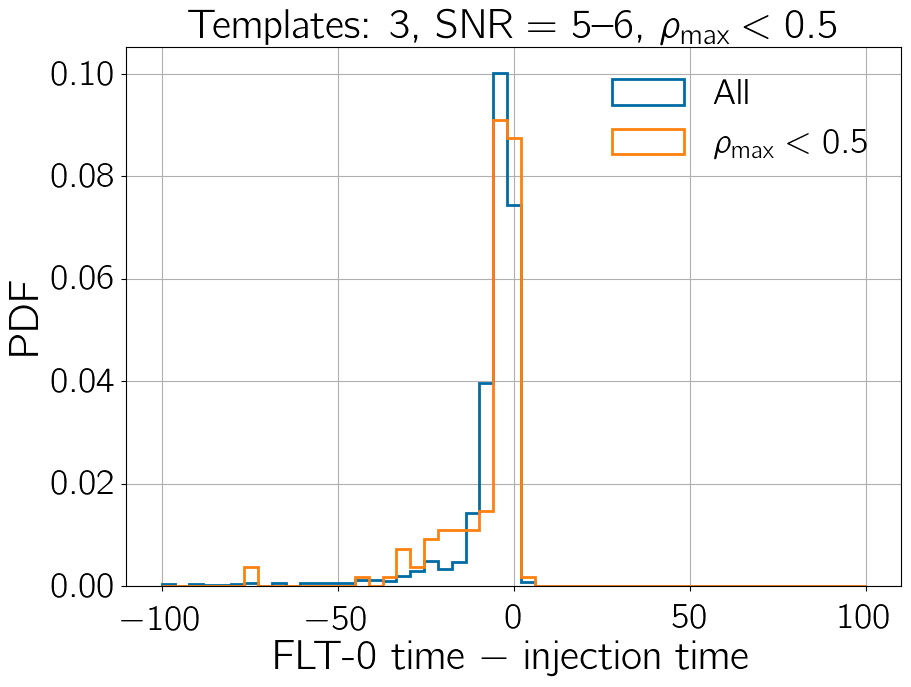

In [13]:
bins_times = np.linspace(-100,100,52)

plt.hist(simu_params_all['pretrig_times']-simu_params_all['inj_pulse_times']-15,bins=bins_times,density=True,histtype='step',linewidth=2.,label='All')
plt.hist(simu_params_below_thresh['pretrig_times']-simu_params_below_thresh['inj_pulse_times']-15,bins=bins_times,density=True,histtype='step',linewidth=2.,label=fr'$\rho_{{\max}} < {corr_thresh}$')
plt.xlabel(r'FLT-0 time $-$ injection time')
plt.ylabel('PDF')
plt.title(title_str)
plt.legend()
plt.show()

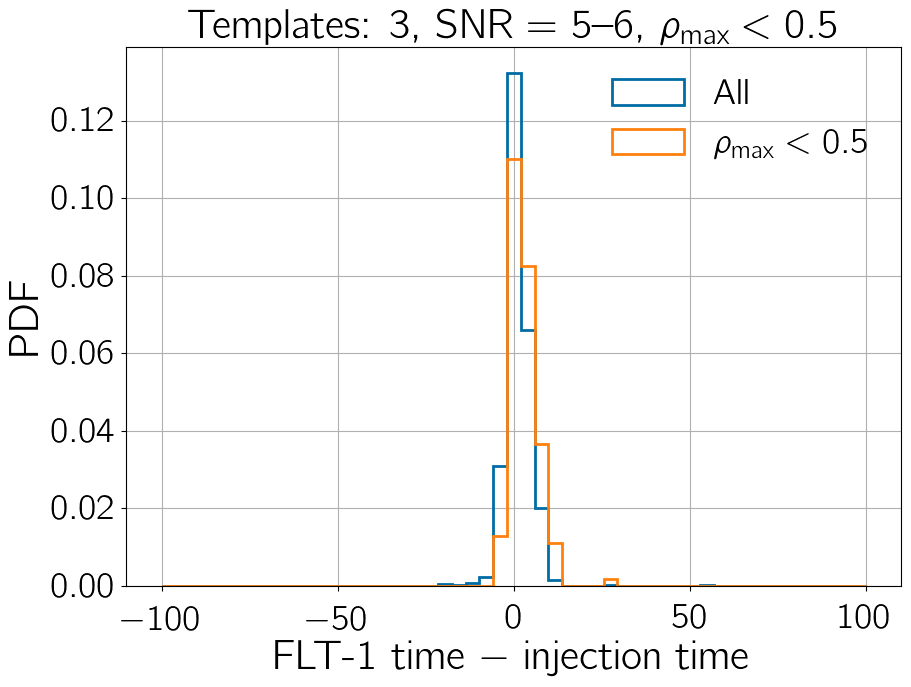

In [14]:
bins_times = np.linspace(-100,100,52)

plt.hist(sig_results['time_best'][snr_masks[snr_bin]]-simu_params_all['inj_pulse_times']-15,bins=bins_times,density=True,histtype='step',linewidth=2.,label='All')
plt.hist(sig_results['time_best'][snr_masks[snr_bin]][mask_low_corr]-simu_params_below_thresh['inj_pulse_times']-15,bins=bins_times,density=True,histtype='step',linewidth=2.,label=fr'$\rho_{{\max}} < {corr_thresh}$')
plt.xlabel(r'FLT-1 time $-$ injection time')
plt.ylabel('PDF')
plt.title(title_str)
plt.legend()
plt.show()

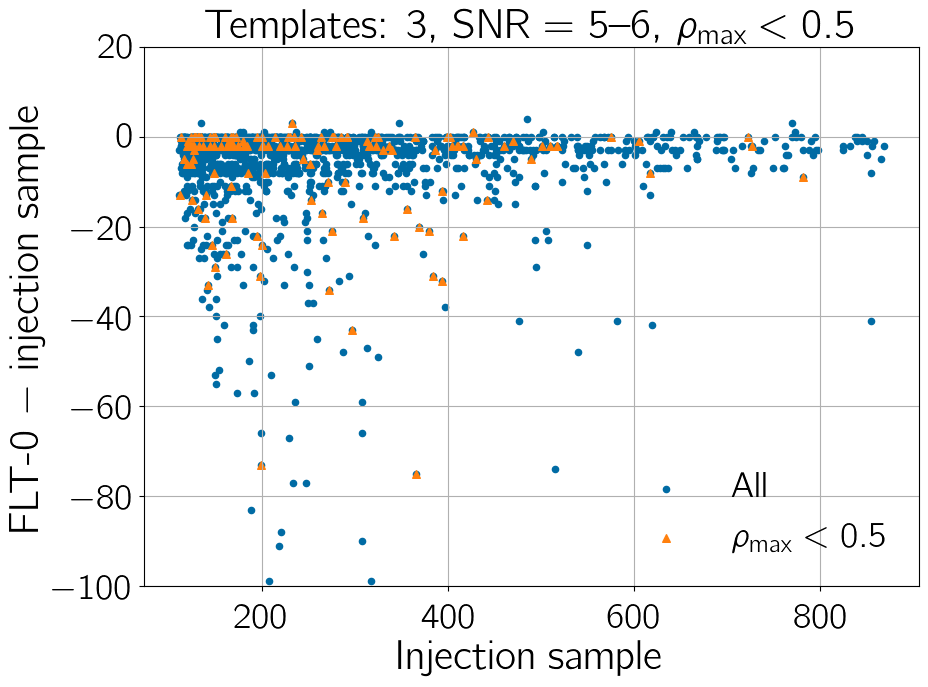

In [15]:
plt.scatter(simu_params_all['inj_pulse_times']-15,simu_params_all['pretrig_times']-simu_params_all['inj_pulse_times']-15,s=20,label='All')
plt.scatter(simu_params_below_thresh['inj_pulse_times']-15,simu_params_below_thresh['pretrig_times']-simu_params_below_thresh['inj_pulse_times']-15,s=30,marker='^',label=fr'$\rho_{{\max}} < {corr_thresh}$')
plt.ylim([-100,20])
plt.xlabel('Injection sample')
plt.ylabel('FLT-0 $-$ injection sample')
plt.title(title_str)
plt.legend()
plt.show()

energy 151110000.0
zenith 79.22000122070312
azimuth 343.5899963378906
omega 0.5396554850551487
omega_c 0.6091703962340013
inj_pulse_times 876.0
pretrig_times 242.0
max_ampl 5.584337647948245
omega_diff 0.11411406662012137
corr_max 0.3830451915121845
time_best 527.0


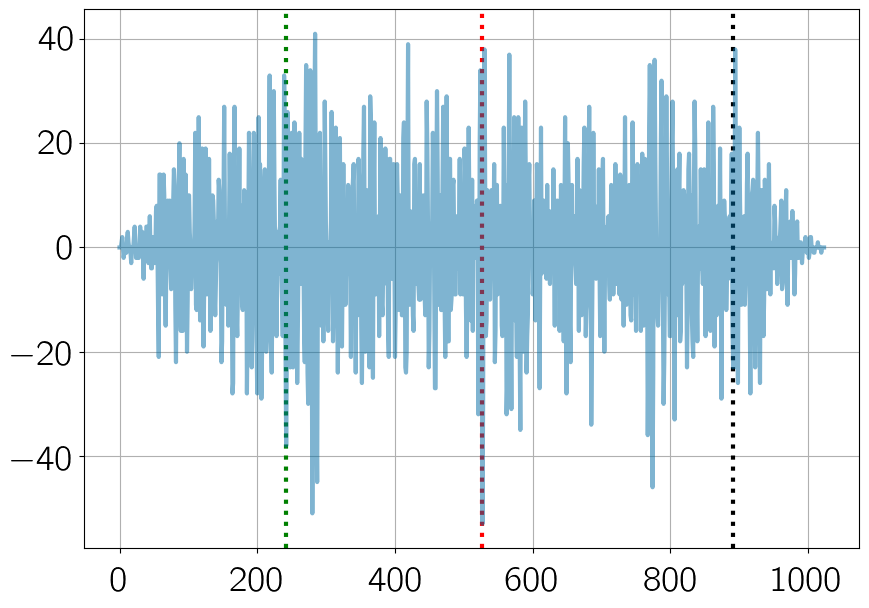

In [25]:
traces_low_corr = traces[mask_low_corr]
idx             = 77

for key in simu_params_below_thresh.keys():
    print(key,simu_params_below_thresh[key][idx])
print('corr_max',corr_snr_bin[mask_low_corr][idx])
print('time_best',sig_results['time_best'][snr_masks[snr_bin]][mask_low_corr][idx])

plt.axvline(simu_params_below_thresh['inj_pulse_times'][idx]+15,color='k',ls=':')
plt.axvline(simu_params_below_thresh['pretrig_times'][idx],color='g',ls=':')
plt.axvline(sig_results['time_best'][snr_masks[snr_bin]][mask_low_corr][idx],color='r',ls=':')
#plt.plot(traces_low_corr[idx,0])
plt.plot(traces_low_corr[idx,0],alpha=.5)
#plt.xlim([400,600])
plt.show()

In [17]:
len(mask_low_corr>0)

142

In [9]:
sig_results['corr_best_all'][snr_masks[snr_bin]][mask_low_corr][idx]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [37]:
sig_results['chi2_all'][snr_masks[snr_bin]][mask_low_corr][idx]

array([[0.1334847 , 0.13715339, 0.17099944, 0.12594692, 0.13473093],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [38]:
sig_results['time_best_all'][snr_masks[snr_bin]][mask_low_corr][idx]

array([[267, 268, 272, 277, 265],
       [  0,   0,   0,   0,   0]])

In [39]:
np.arange(10000)[snr_masks[snr_bin]][mask_low_corr][idx]

675

In [14]:
files[mask_low_corr][idx]

'/sps/grand/pcorrea/nutrig/database/sig/zhaires_proton_rfv2_th1_35_th2_25/sim_plus_noise_GP300_Xi_Sib_Proton_0.481_85.2_199.9_18366_seed_6941.npz'

In [33]:
np.where(files[mask_low_corr]=='/sps/grand/pcorrea/nutrig/database/sig/zhaires_proton_rfv2_th1_35_th2_25/sim_plus_noise_GP300_Xi_Sib_Proton_0.481_85.2_199.9_18366_seed_6941.npz')[0]

array([7])